# Multivariate Time-Series Regression Problem 
Machine Learning models : KNN, Random Forest, Decision Tree and Linear Regression were used to predict four target variables based on 11 input features.


In [51]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPool1D, add, AveragePooling1D, Dense, Dropout, BatchNormalization, Flatten, Input
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime
from google.colab import drive
from os import listdir
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from keras import models, optimizers as opts
tf.keras.optimizers.Optimizer
tf.keras.callbacks.LearningRateScheduler
from numpy import mean
from keras.regularizers import l2


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
base_path =  "/content/gdrive/MyDrive/Deep Learning/DL_project"
# Change the working directory to the base_path
os.chdir(base_path)

In [4]:
df = pd.read_csv('measures_v2.csv')
df.shape

(1330816, 13)

In [5]:
df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [6]:
# change the order of cols
new_cols = ['u_q','coolant','u_d','motor_speed','i_d','i_q','ambient', 'torque','pm','stator_yoke','stator_tooth','stator_winding','profile_id']
df=df.reindex(columns=new_cols)
df.head()

,u_q,coolant,u_d,motor_speed,i_d,i_q,ambient,torque,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.450682,18.805172,-0.350055,0.002866,0.004419,0.000328,19.850691,0.187101,24.554214,18.316547,18.293219,19.086670,17
1,-0.325737,18.818571,-0.305803,0.000257,0.000606,-0.000785,19.850672,0.245417,24.538078,18.314955,18.294807,19.092390,17
2,-0.440864,18.828770,-0.372503,0.002355,0.001290,0.000386,19.850657,0.176615,24.544693,18.326307,18.294094,19.089380,17
3,-0.327026,18.835567,-0.316199,0.006105,0.000026,0.002046,19.850647,0.238303,24.554018,18.330833,18.292542,19.083031,17
4,-0.471150,18.857033,-0.332272,0.003133,-0.064317,0.037184,19.850639,0.208197,24.565397,18.326662,18.291428,19.082525,17


In [10]:
# split the dataset
# Making the profile id 65 and 72 as the two testing sets and rest as the training set
df_test1set = df[(df['profile_id'] == 72)]
df_test2set = df[(df['profile_id'] == 65)]

# Otherthan the 65 and 72, 20, 18 and 6 profiles will be removed to reduce the dataset size. Higher computations needed.
df_trainset = df[(df['profile_id'] != 65) & (df['profile_id'] != 72) & (df['profile_id'] != 20) & (df['profile_id'] != 6) & (df['profile_id'] != 18) & (df['profile_id'] != 13) & (df['profile_id'] != 27) & (df['profile_id'] != 53) & (df['profile_id'] != 56) & (df['profile_id'] != 58)]
# df_trainset = df[(df['profile_id'] == 20)]

In [11]:
df_trainset.drop(['profile_id','torque'],axis = 1,inplace=True)
df_test1set.drop(['profile_id','torque'],axis = 1,inplace=True)
df_test2set.drop(['profile_id','torque'],axis = 1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Preparing the training data set

In [12]:
df_trainset.head()
df_trainset.shape

(983116, 11)

In [13]:
cols = list(df_trainset)[0:12]
print(cols)

['u_q', 'coolant', 'u_d', 'motor_speed', 'i_d', 'i_q', 'ambient', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding']


In [14]:
#New dataframe with only training data - 12 columns
df_for_training = df_trainset[cols].astype(float)

In [15]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [16]:
df_for_training_scaled.shape

(983116, 11)

In [17]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 12. We will make timesteps = 10 (past records data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of records we want to look into the future based on the past records.
n_past = 10  # Number of past records we want to use to predict the future.

In [18]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#Here df_for_training_scaled has a shape (983116, 12)
#983116 refers to the number of data points and 12 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 7:12])   #here, 7:12 represnt the index of varibales we need to predict. Can update this to predict single varible 

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (983106, 10, 11).
trainY shape == (983106, 1, 4).


In [19]:
print(trainX[0])
print(trainY[0])

[[-1.25896404 -0.80940053  0.39863082 -1.20882166  1.02368538 -0.39160665
  -2.37881046 -1.82708059 -1.51839289 -1.70896308 -1.64992031]
 [-1.2561576  -0.80878908  0.39934023 -1.20882308  1.02362741 -0.39161894
  -2.37882066 -1.82796087 -1.51847385 -1.70889245 -1.64971892]
 [-1.25874353 -0.80832368  0.39827095 -1.20882194  1.02363781 -0.391606
  -2.37882882 -1.82760002 -1.51789674 -1.70892416 -1.64982489]
 [-1.25618654 -0.80801347  0.39917357 -1.20881989  1.02361859 -0.39158769
  -2.37883392 -1.82709131 -1.51766665 -1.70899319 -1.65004843]
 [-1.2594238  -0.80703392  0.3989159  -1.20882151  1.02264046 -0.39119977
  -2.378838   -1.82647054 -1.5178787  -1.70904271 -1.65006623]
 [-1.2609472  -0.8050025   0.40438928 -1.20881797  1.01428972 -0.38789265
  -2.37884106 -1.82602301 -1.51802104 -1.70907824 -1.65025693]
 [-1.26351176 -0.80316971  0.40807234 -1.20882249  1.00833035 -0.38549189
  -2.3788431  -1.82586058 -1.51811897 -1.70899395 -1.65034584]
 [-1.26587568 -0.80229583  0.41057657 -1.20

# Preparing the testing data set

In [20]:
print(df_test1set.head())
print(df_test1set.shape)
print(df_test2set.head())
print(df_test2set.shape)

              u_q    coolant        u_d  motor_speed        i_d         i_q  \
984807  -1.887356  30.721162   1.946434     0.022686  -2.001102    1.098022   
984808   0.604919  30.721209   0.109622    27.444022  -8.944310   26.184500   
984809   4.665253  30.721242  -6.753488   116.920677 -35.659968   80.725465   
984810   9.206368  30.721266 -16.699363   251.384409 -59.658771  125.454513   
984811  14.197583  30.720804 -28.559625   418.588814 -77.320911  158.080952   

          ambient         pm  stator_yoke  stator_tooth  stator_winding  
984807  23.886441  37.112483    30.660012     31.291477       32.113178  
984808  23.885538  37.111457    30.708855     31.296847       32.115623  
984809  23.883657  37.116662    30.743853     31.283346       32.122736  
984810  23.880380  36.924837    30.777050     31.283340       32.130268  
984811  23.874869  36.922961    30.820728     31.212032       32.117775  
(15301, 11)
              u_q    coolant       u_d  motor_speed        i_d       

In [21]:
cols = list(df_test1set)[0:12]
print(cols)

['u_q', 'coolant', 'u_d', 'motor_speed', 'i_d', 'i_q', 'ambient', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding']


In [22]:
#New dataframe with only training data - 11 columns
df_for_testing1 = df_test1set[cols].astype(float)
df_for_testing2 = df_test2set[cols].astype(float)

In [23]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the testing 1 dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_testing1)
df_for_testing1_scaled = scaler.transform(df_for_testing1)

# normalize the testing 2 dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_testing2)
df_for_testing2_scaled = scaler.transform(df_for_testing2)

In [24]:
print(df_for_testing1_scaled.shape)
print(df_for_testing2_scaled.shape)

(15301, 11)
(40094, 11)


In [25]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 12. We will make timesteps = 10 (past records data used for training). 

#Empty lists to be populated using formatted training data
test1X = []
test1Y = []
test2X = []
test2Y = []


In [26]:
n_future = 1   # Number of records we want to look into the future based on the past records.
n_past = 10  # Number of past days we want to use to predict the future.
n_feature_predict = 4

In [27]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#Here df_for_training_scaled has a shape (983116, 12)
#983116 refers to the number of data points and 12 refers to the columns (multi-variables).

#for testing set1
for i in range(n_past, len(df_for_testing1_scaled) - n_future +1):
    test1X.append(df_for_testing1_scaled[i - n_past:i, 0:df_for_testing1.shape[1]])
    test1Y.append(df_for_testing1_scaled[i + n_future - 1:i + n_future, 7:12])   #here, 8:12 represnt the index of varibales we need to predict. Can update this to predict single varible 

test1X, test1Y = np.array(test1X), np.array(test1Y)

print('test1X shape == {}.'.format(test1X.shape))
print('test1Y shape == {}.'.format(test1Y.shape))




#for testing set2
for i in range(n_past, len(df_for_testing2_scaled) - n_future +1):
    test2X.append(df_for_testing2_scaled[i - n_past:i, 0:df_for_testing2.shape[1]])
    test2Y.append(df_for_testing2_scaled[i + n_future - 1:i + n_future, 7:12])   #here, 8:12 represnt the index of varibales we need to predict. Can update this to predict single varible 

test2X, test2Y = np.array(test2X), np.array(test2Y)

print('test2X shape == {}.'.format(test2X.shape))
print('test2Y shape == {}.'.format(test2Y.shape))

test1X shape == (15291, 10, 11).
test1Y shape == (15291, 1, 4).
test2X shape == (40084, 10, 11).
test2Y shape == (40084, 1, 4).


In [28]:
print(test1X[0])
print(test1Y[0])
print(test2X[0])
print(test2Y[0])

[[-8.78772845e-01 -7.56371740e-01  3.45559522e-02 -8.12250541e-01
   7.50442825e-01 -4.51270049e-02 -1.80336035e+00 -2.24822679e+00
  -1.15274113e+00 -1.35652784e+00 -1.47226284e+00]
 [-8.25551818e-01 -7.56369847e-01 -9.13754760e-05 -7.97354756e-01
   6.23326560e-01  2.73478543e-01 -1.80566932e+00 -2.24833480e+00
  -1.15037549e+00 -1.35626666e+00 -1.47215309e+00]
 [-7.38845823e-01 -7.56368490e-01 -1.29548453e-01 -7.48749358e-01
   1.34216246e-01  9.66164622e-01 -1.81047760e+00 -2.24778655e+00
  -1.14868043e+00 -1.35692325e+00 -1.47183376e+00]
 [-6.41873056e-01 -7.56367518e-01 -3.17154917e-01 -6.75706134e-01
  -3.05153865e-01  1.53423651e+00 -1.81885482e+00 -2.26799373e+00
  -1.14707256e+00 -1.35692357e+00 -1.47149565e+00]
 [-5.35288682e-01 -7.56386252e-01 -5.40871998e-01 -5.84877562e-01
  -6.28512354e-01  1.94860176e+00 -1.83294313e+00 -2.26819135e+00
  -1.14495711e+00 -1.36039158e+00 -1.47205650e+00]
 [-4.22180826e-01 -7.56391199e-01 -7.91230291e-01 -4.81303549e-01
  -8.65055007e-01  

# Model Development

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline


In [30]:
# Prepare the 3D arrays into required 2D formats

# Training Sets
trainX_new = trainX.reshape(trainX.shape[0],trainX.shape[1]*trainX.shape[2])
trainY_new = trainY.reshape(trainY.shape[0],trainY.shape[1]*trainY.shape[2])

In [31]:
print(trainX_new.shape)
print(trainY_new.shape)

(983106, 110)
(983106, 4)


In [32]:
# Reshaping Testing Sets
test1X_new = test1X.reshape(test1X.shape[0],test1X.shape[1]*test1X.shape[2])
test1Y_new = test1Y.reshape(test1Y.shape[0],test1Y.shape[1]*test1Y.shape[2])
print(test1X_new.shape)
print(test1Y_new.shape)

test2X_new = test2X.reshape(test2X.shape[0],test2X.shape[1]*test2X.shape[2])
test2Y_new = test2Y.reshape(test2Y.shape[0],test2Y.shape[1]*test2Y.shape[2])
print(test2X_new.shape)
print(test2Y_new.shape)

(15291, 110)
(15291, 4)
(40084, 110)
(40084, 4)


# KNN

In [33]:
# hyperparameter tuning to find out optimium value for n_neighbors. Initialy the range was high, due to run time the range reduced to 10. 
R2test = []
MSEtest = []
# Will take some time
for i in range(1,10):
    
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    knn.fit(trainX_new,trainY_new)
    pred_i = knn.predict(test1X_new)
    
    R2test.append(r2_score(test1Y_new, pred_i))
    MSEtest.append(mean_squared_error(test1Y_new, pred_i))

Text(0, 0.5, 'R^2 Rate')

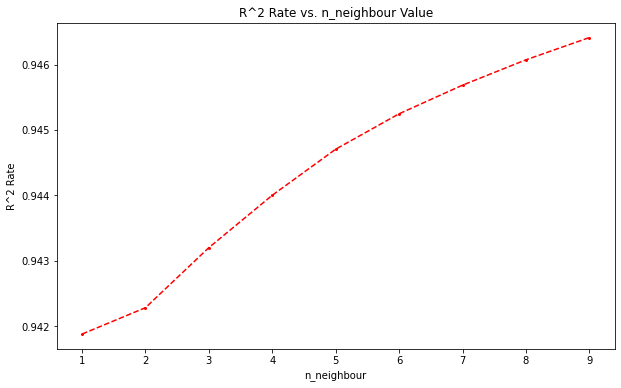

In [34]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),R2test,color='red', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=2, label="R^2")

plt.title('R^2 Rate vs. n_neighbour Value')
plt.xlabel('n_neighbour')
plt.ylabel('R^2 Rate')

Text(0, 0.5, 'MSE Rate')

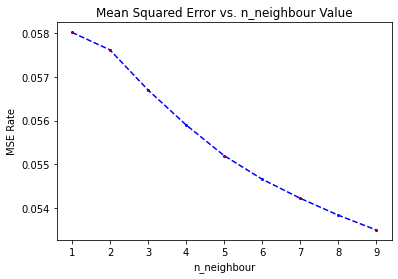

In [35]:
plt.plot(range(1,10),MSEtest,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=2, label = "MSE")
plt.title('Mean Squared Error vs. n_neighbour Value')
plt.xlabel('n_neighbour')
plt.ylabel('MSE Rate')

Train the KNN model with the best neighbour count

In [36]:
knn = neighbors.KNeighborsRegressor(n_neighbors=9)
knn.fit(trainX_new,trainY_new)

KNeighborsRegressor(n_neighbors=9)

In [37]:
# Predicting with two testing sets
test1Y_pred = []
test2Y_pred = []

test1Y_pred= knn.predict(test1X_new)
test2Y_pred= knn.predict(test2X_new)

In [38]:
r2_RF1 = []
r2_RF2 = []

# Predict R2 for test1 dataset
r2_RF1 = r2_score(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 R2:', r2_RF1)
print('test1 average R2:', np.mean(r2_RF1))

# Predict R2 for test2 dataset
r2_RF2 = r2_score(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 R2:', r2_RF2)
print('test2 average R2:', np.mean(r2_RF2))

test1 R2: [0.87941011 0.97278508 0.97857571 0.9548802 ]
test1 average R2: 0.9464127755218275
test2 R2: [0.91268845 0.9752156  0.97836773 0.95684282]
test2 average R2: 0.955778652587283


In [39]:
mse_RF1 = []
mse_RF2 = []

# Predict R2 for test1 dataset

mse_RF1 = mean_squared_error(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 MSE:', mse_RF1)
print('test1 average MSE:', np.mean(mse_RF1))

# Predict R2 for test2 dataset
mse_RF2 = mean_squared_error(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 MSE:', mse_RF2)
print('test2 average MSE:', np.mean(mse_RF2))

test1 MSE: [0.12026994 0.02720919 0.02141234 0.04508523]
test1 average MSE: 0.05349417412577233
test2 MSE: [0.08719031 0.02476963 0.02162005 0.04313624]
test2 average MSE: 0.044179058331179376


In [40]:
mae_RF1 = []
mae_RF2 = []

# Predict mae for test1 dataset
mae_RF1 = mean_absolute_error(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 MAE:', mae_RF1)
print('test1 average MAE:', np.mean(mae_RF1))

# Predict mae for test2 dataset
mae_RF2 = mean_absolute_error(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 MAE:', mae_RF2)
print('test2 average MAE:', np.mean(mae_RF2))

test1 MAE: [0.28476903 0.12547673 0.10795533 0.15471854]
test1 average MAE: 0.16822990704197824
test2 MAE: [0.24059722 0.12102872 0.10686675 0.15163424]
test2 average MAE: 0.15503173143098814


# Random Forest

Hyperparameter optimization

In [41]:
# define the grid search parameters. Due to limited computation power, a very few configurations were used
# n_estimators = [10, 20, 40, 60, 80, 100, 120]
n_estimators = [10, 15]
max_depth = [10, 30]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

RF_model = RandomForestRegressor(bootstrap=True, random_state=0)

grid = GridSearchCV(estimator=RF_model, param_grid=param_grid, n_jobs=-1,  verbose=0)

In [42]:
grid_result = grid.fit(trainX_new, trainY_new)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

In [ ]:
print("\n The best estimators across all searched params:\n",grid.best_estimator_)

In [52]:
# Predicting with two testing sets
test1Y_pred = []
test2Y_pred = []

test1Y_pred= RF_model.predict(test1X_new)
test2Y_pred= RF_model.predict(test2X_new)

NotFittedError: ignored

In [ ]:
r2_RF1 = []
r2_RF2 = []

# Predict R2 for test1 dataset
r2_RF1 = r2_score(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 R2:', r2_RF1)
print('test1 average R2:', np.mean(r2_RF1))

# Predict R2 for test2 dataset
r2_RF2 = r2_score(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 R2:', r2_RF2)
print('test2 average R2:', np.mean(r2_RF2))

In [ ]:
mse_RF1 = []
mse_RF2 = []

# Predict R2 for test1 dataset

mse_RF1 = mean_squared_error(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 MSE:', mse_RF1)
print('test1 average MSE:', np.mean(mse_RF1))

# Predict R2 for test2 dataset
mse_RF2 = mean_squared_error(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 MSE:', mse_RF2)
print('test2 average MSE:', np.mean(mse_RF2))

In [ ]:
mae_RF1 = []
mae_RF2 = []

# Predict mae for test1 dataset
mae_RF1 = mean_absolute_error(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 MAE:', mae_RF1)
print('test1 average MAE:', np.mean(mae_RF1))

# Predict mae for test2 dataset
mae_RF2 = mean_absolute_error(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 MAE:', mae_RF2)
print('test2 average MAE:', np.mean(mae_RF2))

In [ ]:
# Predicting with two testing sets
test1Y_pred = []
test2Y_pred = []

test1Y_pred= grid.predict(test1X_new)
test2Y_pred= grid.predict(test2X_new)

In [ ]:
r2_RF1 = []
r2_RF2 = []

# Predict R2 for test1 dataset
r2_RF1 = r2_score(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 R2:', r2_RF1)
print('test1 average R2:', np.mean(r2_RF1))

# Predict R2 for test2 dataset
r2_RF2 = r2_score(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 R2:', r2_RF2)
print('test2 average R2:', np.mean(r2_RF2))

In [ ]:
mse_RF1 = []
mse_RF2 = []

# Predict R2 for test1 dataset

mse_RF1 = mean_squared_error(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 MSE:', mse_RF1)
print('test1 average MSE:', np.mean(mse_RF1))

# Predict R2 for test2 dataset
mse_RF2 = mean_squared_error(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 MSE:', mse_RF2)
print('test2 average MSE:', np.mean(mse_RF2))

In [ ]:
mae_RF1 = []
mae_RF2 = []

# Predict mae for test1 dataset
mae_RF1 = mean_absolute_error(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 MAE:', mae_RF1)
print('test1 average MAE:', np.mean(mae_RF1))

# Predict mae for test2 dataset
mae_RF2 = mean_absolute_error(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 MAE:', mae_RF2)
print('test2 average MAE:', np.mean(mae_RF2))

# Decision Tree

In [43]:
dec_tree = DecisionTreeRegressor()
scaler = StandardScaler()

In [44]:
pipe = Pipeline( steps = [('Standardscaler', scaler), ('DecisionTree', dec_tree)])

pipe.fit(trainX_new, trainY_new)

Pipeline(steps=[('Standardscaler', StandardScaler()),
                ('DecisionTree', DecisionTreeRegressor())])

In [45]:
# Predicting with two testing sets
test1Y_pred = []
test2Y_pred = []

test1Y_pred= pipe.predict(test1X_new)
test2Y_pred= pipe.predict(test2X_new)

In [46]:
r2_DT1 = []
r2_DT2 = []

# Predict R2 for test1 dataset
r2_DT1 = r2_score(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 R2:', r2_DT1)
print('test1 average R2:', np.mean(r2_DT1))

# Predict R2 for test2 dataset
r2_DT2 = r2_score(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 R2:', r2_DT2)
print('test2 average R2:', np.mean(r2_DT2))

test1 R2: [0.9890324  0.99345941 0.99429536 0.98887943]
test1 average R2: 0.9914166492222719
test2 R2: [0.96523359 0.98496325 0.98480824 0.9796654 ]
test2 average R2: 0.9786676211485045


In [47]:
mse_DT1 = []
mse_DT2 = []

# Predict R2 for test1 dataset

mse_DT1 = mean_squared_error(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 MSE:', mse_DT1)
print('test1 average MSE:', np.mean(mse_DT1))

# Predict R2 for test2 dataset
mse_DT2 = mean_squared_error(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 MSE:', mse_DT2)
print('test2 average MSE:', np.mean(mse_DT2))

test1 MSE: [0.0109385  0.00653922 0.00570146 0.01111205]
test1 average MSE: 0.008572806174374361
test2 MSE: [0.03471814 0.01502779 0.01518318 0.02032473]
test2 average MSE: 0.02131345961647914


In [48]:
mae_DT1 = []
mae_DT2 = []

# Predict mae for test1 dataset
mae_DT1 = mean_absolute_error(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 MAE:', mae_DT1)
print('test1 average MAE:', np.mean(mae_DT1))

# Predict mae for test2 dataset
mae_DT2 = mean_absolute_error(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 MAE:', mae_DT2)
print('test2 average MAE:', np.mean(mae_DT2))

test1 MAE: [0.07210284 0.0581748  0.0512364  0.07210469]
test1 average MAE: 0.06340468220049426
test2 MAE: [0.07609676 0.07806618 0.04651302 0.0627381 ]
test2 average MAE: 0.0658535125796973


# Linear Regression

In [53]:
# pip install statsmodels 

In [61]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

model = LinearRegression(n_jobs=-1)

# Adding a constant will added to ensures that the model will be unbiased, in other words, the mean of the residuals will be zero.
X_train_const = sm.add_constant(trainX_new)

lin_reg = model.fit(X_train_const, trainY_new)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [62]:
# Adding a constant will added to ensures that the model will be unbiased, in other words, the mean of the residuals will be zero.
X_test1_const = sm.add_constant(test1X_new)
X_test2_const = sm.add_constant(test2X_new)


In [63]:
# Predicting with two testing sets
test1Y_pred = []
test2Y_pred = []

test1Y_pred= lin_reg.predict(X_test1_const)
test2Y_pred= lin_reg.predict(X_test2_const)

In [57]:
# print("\n Number of features seen during fit:\n",lin_reg.n_features_in_)

In [64]:
r2_LR1 = []
r2_LR2 = []

# Predict R2 for test1 dataset
r2_LR1 = r2_score(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 R2:', r2_LR1)
print('test1 average R2:', np.mean(r2_LR1))

# Predict R2 for test2 dataset
r2_LR2 = r2_score(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 R2:', r2_LR2)
print('test2 average R2:', np.mean(r2_LR2))

test1 R2: [0.99989697 0.99999597 0.99999724 0.99999419]
test1 average R2: 0.9999710908839347
test2 R2: [0.99994576 0.99999677 0.9999977  0.99999558]
test2 average R2: 0.9999839536659078


In [65]:
mse_LR1 = []
mse_LR2 = []

# Predict R2 for test1 dataset

mse_LR1 = mean_squared_error(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 MSE:', mse_LR1)
print('test1 average MSE:', np.mean(mse_LR1))

# Predict R2 for test2 dataset
mse_LR2 = mean_squared_error(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 MSE:', mse_LR2)
print('test2 average MSE:', np.mean(mse_LR2))

test1 MSE: [1.02752990e-04 4.03152789e-06 2.76167977e-06 5.81006739e-06]
test1 average MSE: 2.8839066384434563e-05
test2 MSE: [5.41651490e-05 3.22612593e-06 2.29895399e-06 4.41442445e-06]
test2 average MSE: 1.6026163337446747e-05


In [66]:
mae_LR1 = []
mae_LR2 = []

# Predict mae for test1 dataset
mae_LR1 = mean_absolute_error(test1Y_new, test1Y_pred, multioutput='raw_values')
print('test1 MAE:', mae_LR1)
print('test1 average MAE:', np.mean(mae_LR1))

# Predict mae for test2 dataset
mae_LR2 = mean_absolute_error(test2Y_new, test2Y_pred, multioutput='raw_values')
print('test2 MAE:', mae_LR2)
print('test2 average MAE:', np.mean(mae_LR2))

test1 MAE: [0.00411205 0.00109258 0.00110296 0.00148193]
test1 average MAE: 0.0019473793220372018
test2 MAE: [0.00334173 0.00111819 0.00098108 0.00121883]
test2 average MAE: 0.0016649581814202818
